# Homework 1, DS-GA 1012, Spring 2019

## Due Feburary 13, 2019 at 2pm (ET)

Download the data zip `DS-GA1012-hw1-data.zip`. Complete the following questions in the notebook and submit your completed notebook on NYU Classes.

## 1. Exploring effect of context size [30 pts]

We face many implicit and explicit design decisions in creating distributional word representations. For example, in lecture and in lab, we created word vectors using a co-occurence matrix built on neighboring pairs of words. We might suspect, however, that we can get more signal of word similarity by considering larger contexts than pairs of words.

__a__. Write `build_cooccurrence_matrix`, which generates the co-occurence matrix for a window of arbitrary size and for the vocabulary of `max_vocab_size` most frequent words. Feel free to modify the code used in lab [10 pts]

In [2]:
def build_cooccurrence_matrix(data, max_vocab_size=20000, context_size=1):
    """ Build a co-occurrence matrix
    
    args:
        - data: iterable where each item is a list of tokens (string) 
        - max_vocab_size: maximum vocabulary size
        - context_size: window around a word that is considered context
            context_size=1 should consider pairs of adjacent words
            
    returns:
        - co-occurrence matrix: numpy array where row i corresponds to the co-occurrence counts for word i"""
    raise NotImplementedError

Use your implementation of `build_cooccurrence_matrix` to generate the co-occurence matrix from the sentences of [SST](http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip) (file `datasetSentences.txt`) with `context_size=2` and `max_vocab_size=10000`. What is the co-occurrence count of the words "the" and "end"? 

__Solution__

In [3]:
import time
from collections import defaultdict
import numpy as np

def build_cooccurrence_matrix(data, max_vocab_size=20000, context_size=2, verbose=True):
    """ 
    
    args:
        - data: iterable where each item is a string sentence
        - max_vocab_size: maximum vocabulary size
        
    returns:
        - coocur_mat: co-occurrence matrix as a numpy array
    """
    
    def get_token_frequencies(context_size):
        tok2freq = defaultdict(int)
        coocur_counts = defaultdict(lambda: defaultdict(int))

        for datum in data:
            for i, tok in enumerate(datum):
                tok2freq[tok] += 1
                for k in range(context_size + 1):
                    if i + k < len(datum):
                        coocur_counts[tok][datum[i+k]] += 1
                        if k != 0:
                            coocur_counts[datum[i+k]][tok] += 1
        return tok2freq, coocur_counts
    
    def prune_vocabulary(tok2freq, max_vocab_size):
        """ Prune vocab by taking max_vocab_size most frequent words """
        tok_and_freqs = [(k, v) for k, v in tok2freq.items()]
        tok_and_freqs.sort(key = lambda x: x[1], reverse=True) # sorts in-place
        tok2idx = {tok: idx for idx, (tok, _) in enumerate(tok_and_freqs[:max_vocab_size])}
        idx2tok = {idx: tok for tok, idx in tok2idx.items()}
        return tok2idx, idx2tok
    
    def _build_coocurrence_mat(idx2tok, coocur_counts):
        #mat = [[coocur_counts[idx2tok[i]][idx2tok[j]] for j in range(len(idx2tok))] for i in range(len(idx2tok))]
        vocab_size = len(idx2tok)
        mat = [[0 for _ in range(vocab_size)] for _ in range(vocab_size)]
        for i in range(vocab_size):
            for j in range(i, vocab_size):
                if coocur_counts[idx2tok[i]][idx2tok[j]]:
                    mat[i][j] = coocur_counts[idx2tok[i]][idx2tok[j]]
                    mat[j][i] = coocur_counts[idx2tok[i]][idx2tok[j]]
        return np.array(mat)
    
    if verbose:
        print("Counting words...")
    start_time = time.time()
    tok2freq, coocur_counts = get_token_frequencies(context_size)
    if verbose:
        print("\tFinished counting %d words in %.5f" % (len(tok2freq), time.time() - start_time))
        print("Pruning vocabulary...")
    tok2idx, idx2tok = prune_vocabulary(tok2freq, max_vocab_size)
    start_time = time.time()
    if verbose:
        print("\tFinished pruning vocabulary to %d words in %.5f" % (len(tok2idx), time.time() - start_time))
        print("Building co-occurrence matrix...")
    start_time = time.time()
    coocur_mat = _build_coocurrence_mat(idx2tok, coocur_counts)
    if verbose:
        print("\tFinished building co-occurrence matrix in %.5f" % (time.time() - start_time))
    return coocur_mat, tok2idx, idx2tok, coocur_counts

In [5]:
def load_sst(data_file):
    with open(data_file, 'r') as data_fh:
        data_fh.readline() # skip the header
        raw_data = [r.split('\t')[1] for r in data_fh.readlines()]
    data = [d.strip().split() for d in raw_data]
    return data

data = load_sst('hw1/DS-GA1012-hw1/datasetSentences.txt')
mat, tok2idx, idx2tok, _ = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=2)

Counting words...
	Finished counting 21701 words in 0.62653
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00001
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 38.50821


In [6]:
tok1 = "the"
tok2 = "end"
print("%s and %s co-occur %d times" % (tok1, tok2, mat[tok2idx[tok1]][tok2idx[tok2]]))

the and end co-occur 98 times


__b__. Plot the effect of varying context size in $\{1, 2, 3, 4\}$ (leaving all the other settings the same) on the quality of the learned word embeddings, as measured by performance (Spearman correlation) on the word similarity dataset [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) between human judgments and cosine similarity of the learned word vectors (see lab). [12 pts]

__Solution__

In [7]:
from scipy.stats import spearmanr

def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(np.dot(u, u))

def cosine_similarity(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    return (np.dot(u, v) / (vector_length(u) * vector_length(v)))

def load_word_similarity_dataset(data_file):
    with open(data_file, 'r') as data_fh:
        raw_data = data_fh.readlines()
    data = []
    trgs = []
    for datum in raw_data:
        datum = datum.strip().split(',')
        data.append((datum[0], datum[1]))
        trgs.append(float(datum[2]))
    return data, trgs

def evaluate_word_similarity(word_pairs, targets, mat, tok2idx):
    """ """
    preds = []
    trgs = []
    n_exs = 0
    for (word1, word2), trg in zip(word_pairs, targets):
        if word1 in tok2idx and word2 in tok2idx:
            pred_sim = cosine_similarity(mat[tok2idx[word1]], mat[tok2idx[word2]])
            preds.append(pred_sim)
            trgs.append(trg)
            n_exs += 1
    
    rho, pvalue = spearmanr(trgs, preds)
    print("Evaluated on %d of %d examples" % (n_exs, len(word_pairs)))
    return rho

In [10]:
test_file = 'hw1/DS-GA1012-hw1/MTURK-771.csv'
test_data, test_trgs = load_word_similarity_dataset(test_file)
scores = []
context_sizes = [1, 2, 3, 4]
for context_size in context_sizes:
    mat, tok2idx, idx2tok, _ = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=context_size)
    score = evaluate_word_similarity(test_data, test_trgs, mat, tok2idx)
    scores.append(score)
print(scores)

Counting words...
	Finished counting 21701 words in 0.60564
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00001
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 34.02603
Evaluated on 248 of 771 examples
Counting words...
	Finished counting 21701 words in 0.92447
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00002
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 41.55725
Evaluated on 248 of 771 examples
Counting words...
	Finished counting 21701 words in 0.99132
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00001
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 35.06092
Evaluated on 248 of 771 examples
Counting words...
	Finished counting 21701 words in 1.02303
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00001
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 38.45037
Evaluated on 

In [11]:
from matplotlib import pyplot as plt

In [12]:
%matplotlib inline

Text(0, 0.5, 'Word similarity correlation')

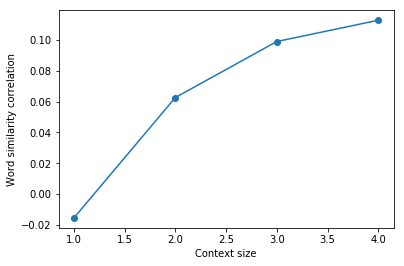

In [13]:
plt.plot(context_sizes, scores, marker='o')
plt.xlabel("Context size")
plt.ylabel("Word similarity correlation")

__c__. Briefly discuss the pros and cons of varying (i) the context size (ii) the vocabulary size (iii) using bigrams instead of unigrams (iv) using subword tokens instead of words. [8 pts]

__Solution__: (i) Larger contexts are generally better for capturing semantics of a word (by capturing longer range correlations), smaller contexts are generally better for capturing syntax of a word.

(ii) With a larger vocab size, we have fewer OOV words, but we must keep an additional vector for each word (and possible an extra dimension for each other word vector, depending on representation). Any losses in speed depend on how your using these word vectors. If you're using them as a lookup table, then we might see small to no loss; if we're performing operations over the entire matrix, then we'll likely see larger slow downs due to increasing vocab size.

(iii) Some concepts might be better represented as bigrams or other higher $n$-grams, but our co-occurrence matrix would likely become very sparse and balloon in size (naively, but this isn't really an issue if you're only taking the top $k$ most frequent tokens). Practically speaking, it isn't that much slower to preprocess the text into bigrams, but there are more of them, so we might see a slow down in building our vocabulary (e.g. if we're sorting bigrams by frequency), but this depends on implementation.

(iv) We can share information between word parts, e.g. lemmas or suffixes, but we need to specify how to break up words into useful subparts and how to combine subparts to form overall token representations. Note that subword tokens does not necessarily mean we're splitting words into characters or prefix/lemma/affix; several state of the art NLU models use BPE. We also artificially increase the length of the sequence by using subparts, which might make it harder to learn with some optimization algorithms.

## 2. Pointwise Mutual Information [20 pts]

In lecture, we introduced __pointwise mutual information__ (PMI), which addresses the issue of normalization removing information about absolute magnitudes of counts. The PMI for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)$$

with $\log(0) = 0$. This is a measure of how far that cell's value deviates from what we would expect given the row and column sums for that cell.

__a__. Implement `pmi`, a function which takes in a co-occurence matrix and returns the matrix with PMI normalization applied. [15 pts]

In [38]:
def pmi(mat):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
    """    
    raise NotImplementedError

Apply PMI to the co-occurence matrix computed above with `context_size=1`. What is the PMI between the words "the" and "end"?

__Solution__

In [39]:
def pmi(mat, ppmi=True):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        - ppmi: boolean; compute PPMI if True
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
    """
    
    
    def _pmi_log_soln(x, positive=True):
        """With `positive=False`, return log(x) if possible, else 0.
        With `positive=True`, log(x) is mapped to 0 where negative."""
        val = 0.0
        if x > 0.0:
            val = np.log(x)
        if positive:
            val = max([val,0.0])
        return val
    
    # Joint probability table:
    p = mat / np.sum(mat, axis=None)
    # Pre-compute column sums:
    colprobs = np.sum(p, axis=0)
    # Vectorize this function so that it can be applied rowwise:
    np_pmi_log = np.vectorize((lambda x : _pmi_log_soln(x, positive=ppmi)))
    p = np.array([np_pmi_log(row / (np.sum(row)*colprobs)) for row in p])   
    return p

In [51]:
pmat = pmi(mat, ppmi=False)

In [50]:
tok1 = "the"
tok2 = "end"
print("%s-%s PMI: %.3f" % (tok1, tok2, pmat[tok2idx[tok1]][tok2idx[tok2]]))

the-end PMI: 1.399


__b__. We also consider an extension of PMI, positive PMI (PPMI), that maps all negative PMI values to 0.0 ([Levy and Goldberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization)). 
Write `ppmi`, which is the same as `pmi` except it applies PPMI instead of PMI (feel free to implement it as an option of `pmi`). What is the PMI of the words "the" and "start"? The PPMI? [5 pts]

__Solution__

In [48]:
ppmat = pmi(mat, ppmi=True)

In [52]:
tok1 = "the"
tok2 = "start"
print("%s-%s PMI: %.3f" % (tok1, tok2, pmat[tok2idx[tok1]][tok2idx[tok2]]))
print("%s-%s PPMI: %.3f" % (tok1, tok2, ppmat[tok2idx[tok1]][tok2idx[tok2]]))

the-start PMI: -0.035
the-start PPMI: 0.000


## 3. Analyzing PMI [25 pts]

__a__. Consider the matrix `np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])`. Reweight this matrix using `ppmi`. (i) What is the value obtained for cell `[0,0]`, and (ii) give a brief description for what is likely problematic about this value. [10 pts]

__Solution__: 1.609 is far too large of a value relative to the rest of the matrix. PMI is biased towards infrequent events and so it gives this far too large of a probability.

In [58]:
tmp = pmi(np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]]))
print(tmp)

[[1.60893804 0.         0.        ]
 [0.         0.         0.28788209]
 [0.22289371 0.51107566 0.        ]]


__b__. Give a suggestion for dealing with the problematic value and explain why it deals with this. Demonstrate your suggestion empirically [10 pts]

__Solution__: Use add-2 smoothing or any other kind of smoothing. This creates pseudocounts of rare events making them relatively less rare.

In [57]:
tmp = pmi(np.array([[3.0, 2.0, 2.0], [1002.0, 1002.0, 4002.0], [1002.0, 2002.0, 1001.0]]), ppmi=True)
tmp

array([[0.76044454, 0.        , 0.        ],
       [0.        , 0.        , 0.28798133],
       [0.22219683, 0.51037628, 0.        ]])

__c__. Consider starting with a word-word co-occurence matrix and applied PMI to this matrix. (i) Which of the following describe the resulting vectors: sparse, dense, high-dimensional, low-dimensional (ii) If you wanted the opposite style of representation, what could you do? [5 pts]


__Solution__:

i. sparse, high-dimensional

ii. LSA or SVD-inspired methods as they are dense and relatively low-dimensional.

## 4. Word Analogy Evaluation [25 pts]

Word analogies provide another kind of evaluation for distributed representations. Here, we are given three vectors A, B, and C, in the relationship

_A is to B as C is to __ _

and asked to identify the fourth that completes the analogy. These analogies are by and large substantially easier than the classic brain-teaser analogies that used to appear on tests like the SAT, but it's still an interesting, demanding
task. 

The core idea is that we make predictions by creating the vector $(A - B) + C$,ranking all vectors based on their distance from this new vector, and choosing the closest as our prediction.

__a__. Implement the function `analogy_completion`. [9 pts]

In [ ]:
def analogy_completion(a, b, c, mat):
    """ """
    raise NotImplementedError

__Solution__

In [1]:
def analogy_completion(a, b, c, mat, tok2idx, idx2tok):
    """Compute ? in 
    a is to b as c is to ? 
    as the closest to (b-a) + c
    
    args:
        - a, b, c: words (strings)
        - mat: matrix of word vectors
        - idx2tok (optional, depending on your implementation): dict mapping matrix rows to tokens
        - tok2idx (optional, depending on your implementation): dict mapping tokens to matrix rows
    
    returns:
        - list of the top words
    """
    
    def cosine_dist(u, v):        
        """Cosine distance between 1d np.arrays `u` and `v`, which must have 
        the same dimensionality. Returns a float."""
        return 1.0 - (np.dot(u, v) / (np.sqrt(np.dot(u, u)) * np.sqrt(np.dot(v, v))))

    for x in (a, b, c):
        if x not in tok2idx:
            raise ValueError('%s is OOV!' % x)
    avec = mat[tok2idx[a]]
    bvec = mat[tok2idx[b]]
    cvec = mat[tok2idx[c]]
    newvec = (bvec - avec) + cvec
    dists = [(w, cosine_dist(newvec, mat[i])) for w, i in tok2idx.items() if w not in (a, b, c)]
    return [w for w, _ in sorted(dists, key=lambda x: x[1], reverse=False)]

__b__. Our simple word embeddings likely won't perform well on this task. Let's instead look at some high quality pretrained word embeddings. Write code to load 300-dimensional [GloVe word embeddings](http://nlp.stanford.edu/data/glove.840B.300d.zip) trained on 840B tokens. Each line of the file is formatted as a word followed by 300 floats that make up its corresponding word embedding (all space delimited). The entries of GloVe word embeddings are not counts, but instead are learned via machine learning. Use your `analogy_completion` code to complete the following analogies using the GloVe word embeddings. [6 pts]

- "Beijing" is to "China" as "Paris" is to ?
- "gold" is to "first" as "silver" is to ?
- "Italian" is to "mozzarella" as "American" is to ?
- "research" is to "fun" as "engineering" is to ?

__Solution__

In [2]:
def load_glove(glove_file, n_vecs=20000):
    """ """
    tok2vec = {}
    with open(glove_file, 'r') as glove_fh:
        for i, row in enumerate(glove_fh):
            word, vec = row.split(' ', 1)
            tok2vec[word] = np.array([float(n) for n in vec.split(' ')])
            if i >= n_vecs:
                break
    return tok2vec

def glove_analogy_completion(a, b, c, vecs):
    """Compute ? in 
    a is to b as c is to ? 
    as the closest to (b-a) + c
    
    args:
        - a, b, c: words (strings)
        - mat: matrix of word vectors
        - idx2tok (optional, depending on your implementation): dict mapping matrix rows to tokens
        - tok2idx (optional, depending on your implementation): dict mapping tokens to matrix rows
    
    returns:
        - list of the top words
    """
    
    def cosine_dist(u, v):        
        """Cosine distance between 1d np.arrays `u` and `v`, which must have 
        the same dimensionality. Returns a float."""
        return 1.0 - (np.dot(u, v) / (np.sqrt(np.dot(u, u)) * np.sqrt(np.dot(v, v))))

    for x in (a, b, c):
        if x not in vecs:
            raise ValueError('%s is OOV!' % x)
    avec = vecs[a]
    bvec = vecs[b]
    cvec = vecs[c]
    newvec = (bvec - avec) + cvec
    dists = [(w, cosine_dist(newvec, vec)) for w, vec in vecs.items() if w not in (a, b, c)]
    return sorted(dists, key=lambda x: x[1], reverse=False)

In [3]:
glove_file = "glove.840B.300d.txt"
glove_vecs = load_glove(glove_file, n_vecs=30000)

FileNotFoundError: [Errno 2] No such file or directory: 'glove.840B.300d.txt'

In [44]:
glove_analogy_completion("Italian", "mozzarella", "American", glove_vecs)[0][0]

'cheddar'

c. Let's get a more quantitative, aggregate sense of the quality of GloVe embeddings. Load the analogies from `gram6-nationality-adjective.txt` and evaluate GloVe embeddings. Report the mean reciprocal rank of the correct answer (the last word on each line) for each analogy. [10 pts]

__Solution__

In [13]:
def analogy_evaluation(glove_vecs, test_file, verbose=False):
    """Basic analogies evaluation for a file `src_filename`
    in `question-data/`.
    
    Parameters
    ----------    
    mat : 2d np.array
        The VSM being evaluated.
        
    rownames : list of str
        The names of the rows in `mat`.
        
    src_filename : str
        Basename of the file to be evaluated. It's assumed to be in
        `vsmdata_home`/question-data.
        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors.
    
    Returns
    -------
    (float, float)
        The first is the mean reciprocal rank of the predictions and 
        the second is the accuracy of the predictions.
    
    """
    # Read in the data and restrict to problems we can solve:
    data = [line.split() for line in open(test_file).read().splitlines()]
    data = [prob for prob in data if set(prob) <= set(glove_vecs.keys())]
    # Run the evaluation, collecting accuracy and rankings:
    results = defaultdict(int)
    ranks = []
    for a, b, c, d in data:
        predicted = glove_analogy_completion(a, b, c, glove_vecs)
        if verbose:
            print("%s is to %s as %s is to %s (actual is %s)" % (a, b, c, predicted[0][0], d))
        results[predicted[0][0] == d] += 1
        predicted_words, _ = zip(*predicted)
        ranks.append(predicted_words.index(d))
    # Return the mean reciprocal rank and the accuracy results:
    mrr = np.mean(1.0/(np.array(ranks)+1))
    return (mrr, results)

In [16]:
analogy_evaluation(glove_vecs, "gram6-nationality-adjective.txt")

(0.9391509433962264, defaultdict(int, {True: 97, False: 9}))